<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from tqdm.notebook import tqdm
from time import time

In [2]:
RANDOM_STATE = 42

## Подготовка

Загрузим даннные и посмотрим, как выглядит датасет, как распределен целевой признак

In [3]:
comments_data = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
comments_data = comments_data.drop(columns=['Unnamed: 0'], axis=1)

In [5]:
def info_fuc(df):
    display(df.sample())
    display(df.info())
    print(f'Количество пропущенных значений:\n{df.isna().sum()} \
    \nКоличество явных дубликатов: {df.duplicated().sum()}')
info_fuc(comments_data)

,text,toxic
63646,"i doubt he ever SERIOUSLY considered college, ...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

Количество пропущенных значений:
text     0
toxic    0
dtype: int64     
Количество явных дубликатов: 0


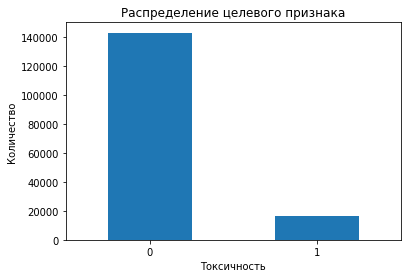

In [6]:
comments_data['toxic'].value_counts().plot(kind='bar')
plt.title('Распределение целевого признака')
plt.xlabel('Токсичность')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.show()

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# Функция для получения POS-тега в формате wordnet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # по умолчанию считаем существительным

In [10]:
def proper_lemmatize(text):
    # Токенизация и получение POS-тегов
    tokens = nltk.word_tokenize(text.lower())
    pos_tags = nltk.pos_tag(tokens)
    
    lemmatized_words = []
    for word, tag in pos_tags:
        if word.isalpha():  # пропускаем не-слова
            wordnet_pos = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(word, wordnet_pos)
            lemmatized_words.append(lemma)
    
    return ' '.join(lemmatized_words)

def lemmatize_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [11]:
tqdm.pandas()
comments_data['lemme_lext'] = comments_data['text'].progress_apply(proper_lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
# код ревьюера

comments_data.head()

,text,toxic,lemme_lext
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,he match this background colour i seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i really not try to edit war it just t...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca make any real suggestion on improvem...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


- Дисбаланс целевого признака - перекос в сторону нетоксичных комментариев.
- При разделении на выборки нужно будет стратифицировать по целевому признаку


- Для лемматизации будем использовать `WordNetLemmatizer()`, комментарии в твитах представлены на английском языке
- При лемматизации нужно привести текст к нижнему регистру и убрать все спец.символы, ссылки и адреса - только так получилось поднять метрику f1 до приемлемого значения

## Обучение

- Для векторизации применим `TfidfVectorizer`
- Моделью классификации выберем `LogisticRegression` с гиперпараметрами `max_iter=1000, C=0.8` и также учтем балансировку классов

In [13]:
X = comments_data['lemme_lext']
y = comments_data['toxic']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [15]:
# Определение моделей
models = {
    'LogisticRegression': {
        'model': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ]),
        'params': {
            'model__C': [0.1, 1.0]
        }
    },
    'LinearSVC': {
        'model': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('model', LinearSVC(random_state=RANDOM_STATE))
        ]),
        'params': {
        }
    }
}

In [16]:
# Словарь для хранения лучших моделей и их оценок
best_models = {}
best_scores = {}

# Обучение и подбор гиперпараметров для каждой модели
for name, config in tqdm(models.items(), desc="Обучение моделей"):
    print(f"Обучение модели: {name}")
    start_time = time()

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
        
    grid.fit(X_train, y_train)
        
    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_
    
    print(f"Время выполнения: {time() - start_time:.2f} сек")
    print(f"Лучшая оценка F1_score: {grid.best_score_:.4f}")
    print(f"Лучшие параметры: {grid.best_params_}\n")

# Вывод лучших моделей и их F1_score
print("Лучшие модели и их оценки F1_score:")
for name, score in best_scores.items():
    print(f"{name}: F1_score = {score:.4f}")

Обучение моделей:   0%|          | 0/2 [00:00<?, ?it/s]

Обучение модели: LogisticRegression
Время выполнения: 255.30 сек
Лучшая оценка F1_score: 0.7239
Лучшие параметры: {'model__C': 1.0}

Обучение модели: LinearSVC
Время выполнения: 23.95 сек
Лучшая оценка F1_score: 0.7784
Лучшие параметры: {}

Лучшие модели и их оценки F1_score:
LogisticRegression: F1_score = 0.7239
LinearSVC: F1_score = 0.7784


Проведем блайнд-тест на тестовой выборке лучшей модели

In [17]:
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
test_pred = best_model.predict(X_test)

In [20]:
print('Метрика F1 на тестовой выборке:', f1_score(y_test, test_pred))

Метрика F1 на тестовой выборке: 0.7871056714359593


## Выводы

1. Загрузили и преобработали данные
    - Привели к нижнему регистру
    - Убрали спец.символы, лишние символы, HTML-теги, URL, упоминании
2. Обнаружили дисбаланс целевого признака
    - При разделении на обучающую и тестовую выборку стратифицировали данные по целевому признаку
3. Векторизировали данные при помощи `TfidfVectorizer()`
4. Выбрали и обучили модели `LogisticRegression` с гиперпараметрами `max_iter=1000, C=1` и `SVC`


**Получили следующие метрики f1-score на кросс-валидации:**

- `Logistic Regression F1: 0.7239`
- `Linear SVM F1: 0.7784`

Лучшей моделью стала модель опорных векторов. Лучшая метрика f1, а также время обучения `24.20 сек`

На тестовой выборке лучшая модель показала `f1_score = 0.787`

Улучшить значение метрики можно добавив гиперпараметры в векторизация (но в тренажере умирает ядро по кд), использовать другую библиотеку для лемматизации текстов и использоваться другие модели (бустинги или нейронные), использовать BERT вместо TDIDF